# Clustering Using Expectation Maxmization Algorithm

## Introduction
In this notebook, I'll use Gaussian Mixture Model (GMM) and Expectation Maximization algorithm to cluster a two dimensional dataset and visualize the result. We assume that the features of the dataset used here will follow normal distribution with a mean $\mu$ and a covariance matrix $\sigma$.


## Table of Content
* [Creating Dataset Generator](#first)
* [Modeling E-Step](#second)
* [Modeling M-Step](#third)
* [Defining Metric and General EM Algorithm](#fourth)
* [Creating Visualization Tools](#fifth)
* [Testing with 2 Clusters](#sixth)
* [Testing with 4 Clusters](#seventh)
* [Conclusion](#eighth)

## Creating Dataset Generator <a class="anchor" id="first"></a>
We'll start off by creating a function that can generate a dataset to be classified with. This generator can produce dataset of any arbitrary number of clusters given the mean and covariance matrix. However, the dimension of the mean and covariance matrix must agree, which should be number of actual clusters in total.

In [1]:
import csv, copy, gzip, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import chi2

In [2]:
def dataset_factory(mu, sig, size):
    """
    creats a dataset as numpy array based on the input mean, covariance matrix and total number of datapoints
    """
    assert len(mu) == len(sig)
    size_c = int(size/len(mu)) # create same num of datapoints for each cluster
    X = []
    Y = []
    for c in range(len(mu)):
        x_c, y_c = np.random.multivariate_normal(mu[c], sig[c], size_c).T
        X = np.concatenate((X, x_c))
        Y = np.concatenate((Y, y_c))
    data = np.array([X, Y]).T
    return data

## Modeling E-Step <a class="anchor" id="second"></a>
In the E-step, we need to calculate the class condition probability $p_{n,k}$ of a given datapoint with respect to all clusters. <br>
We know that since it's class conditional probability, then for a given datapoint with index n: $$p_{n} = \Sigma_k p_{n,k} = 1$$ <br>
Then, by Bayes theorem, we can express the class conditional probability as: $$p_{n,k} = p(C_k|n) =  \frac{p(n|C_k)p(C_k)}{p(n)}$$ <br>
If we rule out the normalizing constant for now and get an approximation of it by multiplying the likelihood with a cluster weight, we have: $$p_{n,k} \propto \lambda_k\mathcal{N}(x_n|\mu_k, \Sigma_k)$$ where $\mu_k$ is the mean and $\Sigma_k$ is the covariance matrix of cluster $k$ <br>
Then, we can normalize the approximation by dividing the normalizing constant, which should be the sum over all clusters of the likelihood multiplied by corresponding cluster weights for each datapoint: $$p_{n,k} = \frac{\lambda_k\mathcal{N}(x_n|\mu_k, \Sigma_k)}{\Sigma^K_k\lambda_k\mathcal{N}(x_n|\mu_k, \Sigma_k)}$$, where in the denominator, the first $\Sigma_k^K$ is the summation mark while the second $\Sigma_k$ is the cluster covariance matrix

In [3]:
def expectation(data, means, covs, weights):
    """
    returns the expectation of each datapoint wrt each cluster
    """
    T = len(data)  # number of datapoint
    K = len(means)  # number of clusters
    p_nk = np.zeros((T, K))  # a matrix that stores the pdf of each datapoint wrt each cluster
    
    for i in range(T):
        for c in range(K):
            p_nk[i, c] = weights[c] * multivariate_normal.pdf(data[i], means[c], covs[c])
    p_nk = p_nk / p_nk.sum(axis=1)[:, np.newaxis] # normalize the pdf by dividing the row sum
   
    return p_nk

## Modeling M-Step <a class="anchor" id="third"></a>

After we get produced class conditional probability of each datapoint with respect to each clusters, we need to optimize the Gaussian distribution parameters. At M-step, we need to update the cluster weight $\lambda_c$, the cluster means $\mu_c$ and the cluster covariance matrics $\Sigma_c$ based upon the data and the result from E-step.

- We first define a function that will calculate the new mean $\mu_c$ for each cluster. The new cluster mean should be the datapoints' product with its class conditional probability summed over all datapoints, and then normalize the sum by dividing the probability of that cluster: $$\mu_k = \frac{\Sigma_n p_{n,k}*x^{(n)}}{p_k}$$

In [4]:
def next_mean (data, p_nk, count):
    """
    update mu value for M-step
    """
    T = len(data) # number of datapoints
    K = len(np.sum(p_nk, axis=0)) # number of clusters
    new_means = [np.zeros(len(data[0]))]*K # new mu value for each cluster
    for c in range(K):
        cumsum = 0
        for i in range(T):
            cumsum += p_nk[i, c] * data[i]
        new_means[c] = cumsum * 1 / count[c] # weighted by marginal prob

    return new_means

- Then, we update the covariance matrix $\Sigma_k$ of each cluster. It is a weighted average. It should be the outer product summed over all datapoints weighted by the probability of the cluster: $$\Sigma_k = \frac{\Sigma_n p_{n,k}(x^{(n)}-\mu_k)(x^{(n)}-\mu_k)^T}{p_k}$$ <br>
The result of the outer product should be: $$\Sigma = \left( \begin{array}{cc}
\sigma_{x}^2 & \sigma_{xy}^2 \\
\sigma_{xy}^2 & \sigma_{y}^2 \\
 \end{array} \right) $$

In [5]:
def next_cov (data, p_nk, mu, count):
    """
    update Sigma value (covariance matrix) for M-step
    """
    T = len(data) # number of datapoints
    K = len(count) # number of clusters
    F = len(data[0]) # number of features
    new_cov = [np.zeros((F, F))] * K # new covariance matrix for each cluster

    for c in range(K):
        cumsum = np.zeros((F, F))

        for i in range(T):
            cumsum += p_nk[i, c] * np.outer((data[i] - mu[c]), (data[i] - mu[c]).T)
        new_cov[c] = cumsum/count[c] # weighted by marginal prob

    return new_cov

- Lastly we calculate the new weights $\lambda_k$ for each cluster by dividing number of datapoints in this cluster with number of total datapoints in this dataset: $$\lambda_k = \frac{N_k}{N}$$

In [6]:
def next_weights (p_nk, count):
    """
    update lambda value for M-step
    """
    K = len(count) # number of clusters
    weights = np.zeros(K)

    for c in range(K):
        weights[c] = count[c] / np.sum(count) # calculate new weight of each cluster
    
    return weights

Then we have the general maximization function

In [7]:
def maximization(data, means, covs, weights, p_nk):
    """
    updates mu, Sigma and lambda value
    """
    count = np.sum(p_nk, axis=0)
    
    new_means = next_mean(data, p_nk, count)
    new_covs = next_cov(data, p_nk, new_means, count)
    new_weights = next_weights(p_nk, count)

    return new_means, new_covs, new_weights

## Defining Metric and General EM Algorithm <a class="anchor" id="fourth"></a>
Log likelihood is a good way to measure how "optimized" our model is. The more its gradient is close to zero ("level off"), the better our model is, which means we achieved the maximum likelihood for the data. So we need set a threshold for it such that we can exit the looping of EM algorithm when the log likelihood graident is below the threshold.

In [8]:
def log_likelihood(data, means, covs, weights):
    """
    calculate current log likelihood of all datapoints
    """
    K = len(means)
    F = len(data[0])
    ll = 0
    
    for d in data:
        Z = np.zeros(K)
        for k in range(K):
            delta = np.array(d) - means[k]
            exp = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            # log likelihood of this datapoint affected by this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2 * (F * np.log(2 * np.pi) + np.log(np.linalg.det(covs[k])) + exp)
        # sum of log likelihood of all datapoints
        ll += np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))
            
    return ll

Combining expectation function, maximization function and metric function together, we have our EM algorithm:

In [9]:
def EM_algo(data, init_means, init_covs, init_weights, iterations=30, thresh=0.01):
    """
    perform expectation maximization algorithm on the input dataset
    return the Gaussian Mixture Model when max iteration is reached or change in log-likelihood is lower than threshold
    """
    means = init_means[:]
    covs = init_covs[:]
    weights = init_weights[:]
    log_like = log_likelihood(data, means, covs, weights)
    ll_trace = [log_like]
    curr_iters = 0

    while iterations > curr_iters:
        curr_iters += 1
        # E-step: update label on each datapoint
        p_nk = expectation(data, means, covs, weights)
        # M-step: update parameters of each cluster based on actual data
        means, covs, weights = maximization(data, means, covs, weights, p_nk)
        # update log likelihood
        log_like = log_likelihood(data, means, covs, weights)
        # append to trace array
        ll_trace.append(log_like)
        if (log_like - ll_trace[-2] < thresh) and (log_like > -np.inf):
            break
    
    final_gmm = []
    for c in range(len(means)):
        final_gmm.append({'mean' : means[c], 'covariance' : covs[c], 'weight' : weights[c]})

    return final_gmm, ll_trace

## Creating Visualization and Initialization Tools <a class="anchor" id="fifth"></a>
Before we go straight to test our model, we also need to create tools for data visualization. Based on how we constructed our EM algorithm, we need to create 2 types plot. One is plotting the original datapoints with ellipses corresponding to Gaussian distributions in one graph. The other is the change of log likelihood, our metric, over each iterations.

In [10]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    plt.xlabel('PCA 1'); plt.ylabel('PCA2')
    plt.title('Clustering of 2D GMM')
    

def colorPicker(index):
    colors = 'cmykrgb'
    return colors[np.remainder(index, len(colors))]


def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))


def traceplot(ll_trace):
    plt.plot(ll_trace, 'o-')
    plt.xlabel('Iterations'); plt.ylabel('Log-likelihood')
    plt.title('Change of Log-likelihood')
    

def doubleplot(data, gmm, ll_trace, size):
    """
    plot the traceplot and gmmplot
    """
    fig = plt.figure(figsize=(size[0], size[1])) 
    plt.subplot(1, 2, 1)
    gmmplot(data, gmm)
    plt.subplot(1, 2, 2)
    traceplot(ll_trace)

Besides that, we also need tools that can help us create a random initialization state for our model. Obviously, we don't want to hard code initial mean, covariance matrix and weight every time we use it, especially if the number of clusters are high.

In [11]:
def covmatIsLegal(sigma):
    """
    check if input covariance matrix is legal
    """
    sigma = np.array(sigma)
    for covmat in sigma:
        if not(np.allclose(covmat, np.array(covmat).T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True


def randinitCovariance(n):
    sigma = []
    for m in range(n):
        # randomly pick a direction
        angle = np.random.uniform(0, 2 * np.pi)
        # create eigen vector with the direction and direction orthogonal to it
        eigenVector = np.asarray([[np.cos(angle), np.sin(angle)],
                                  [np.cos(angle + np.pi/2), np.sin(angle + np.pi/2)]])
        # randomly generate eigen values
        eigenValue = abs(np.random.normal(size=2))
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    # return in form of numpy.ndarray
    return sigma


def random_init(K):
    """
    return randomly initialized mu, Sigma and lambda value with K as number of anticipated clusters
    """
    init_mu = []
    for c in range(K):
        init_mu.append(np.random.randint(10, size=(1, 2)).tolist()[0])
    init_lambda = [1/K]*K
    init_sig = randinitCovariance(K)
    return init_mu, init_sig, init_lambda

## Testing with 2 Clusters <a class="anchor" id="sixth"></a>
Finally, let's test our algorithm with a dataset of 2 clusters

c:\users\f4ced\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


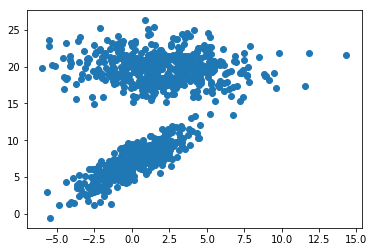

In [12]:
# define mu a sigma for the clusters
mu = [[2, 20],
       [0, 7]]
sig = [[[9, 0], [0, 4]],
        [[5, 6], [0, 1]]]
size = 1000
# generate and plot the dataset
np.random.seed(2)
dataset = dataset_factory(mu, sig, size)
plt.scatter(dataset[:,0], dataset[:,1])

In [14]:
# initialize parameters, 
init_means, init_covs, init_weights = random_init(2)
# run EM algorithm
final_gmm, ll_trace = EM_algo(dataset, init_means, init_covs, init_weights)

final_gmm

[{'mean': array([0.13564226, 7.07160148]),
  'covariance': array([[3.27571057, 3.33487129],
         [3.33487129, 4.74249418]]),
  'weight': 0.4993832030331176},
 {'mean': array([ 1.9652654 , 19.82650165]),
  'covariance': array([[ 9.06961336, -0.47109751],
         [-0.47109751,  4.08437466]]),
  'weight': 0.5006167969668823}]

The final Gaussian Mixture Model stores the mean, covariance and weight value in dictionaries for all the clusters. Now let's visualize our clustering and the change of log likelihood over iterations

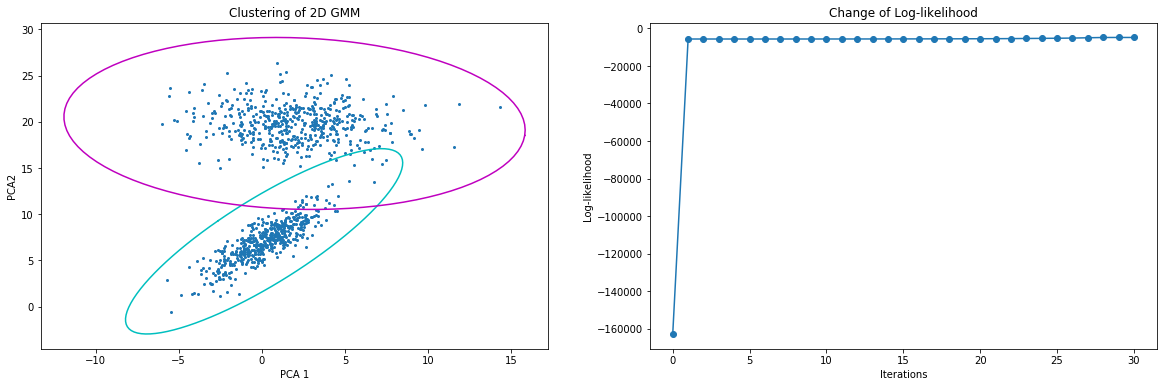

In [15]:
doubleplot(dataset, final_gmm, ll_trace, [20, 6])

Looks great. On the left, 2 ellipse seems accurately centered at the mean of the data, while on the right, the log likelihood leveled off within the first five iterations and stoped at iteration 30, which is the default max iteration.

## Testing with 4 Clusters <a class="anchor" id="seventh"></a>
Since all the functions are generalizable to any arbitray number of clusters, we don't have to modify anything, just need to create a new dataset and test it.

c:\users\f4ced\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


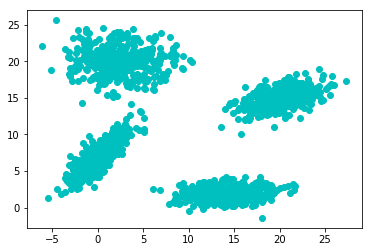

In [16]:
# define mu a sigma for the clusters
mu = [ [2, 20],
       [0, 7],
       [14, 2],
       [20, 15]]
sig = [ [[9, 0], [0, 4]],
        [[5, 6], [0, 1]],
        [[6, 1], [7, 0]],
        [[6, 2], [2, 2]]]
size = 1500
# generate and plot the dataset
np.random.seed(4)
dataset = dataset_factory(mu, sig, size)
plt.scatter(dataset[:,0], dataset[:,1], color='c')

In [17]:
# initialize parameters, intentionally bad so it can improve over time
init_means, init_covs, init_weights = random_init(4)

# run EM algorithm
final_gmm, ll_trace = EM_algo(dataset, init_means, init_covs, init_weights)
final_gmm

[{'mean': array([0.01846862, 6.97426862]),
  'covariance': array([[3.14982818, 2.97139889],
         [2.97139889, 4.18394927]]),
  'weight': 0.24925506057451646},
 {'mean': array([14.09426361,  1.98453412]),
  'covariance': array([[8.12943917, 0.48254834],
         [0.48254834, 0.69274322]]),
  'weight': 0.2295402855703462},
 {'mean': array([15.45440092,  1.76270398]),
  'covariance': array([[ 4.03205466, -0.59436696],
         [-0.59436696,  1.30656298]]),
  'weight': 0.020459743246576977},
 {'mean': array([11.18355347, 17.5533421 ]),
  'covariance': array([[ 85.33652089, -21.89969119],
         [-21.89969119,   9.33938006]]),
  'weight': 0.5007449106085604}]

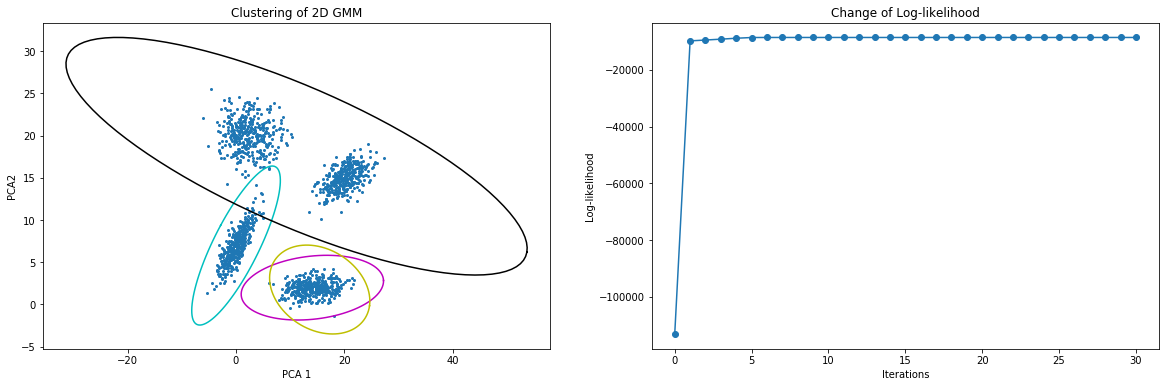

In [18]:
doubleplot(dataset, final_gmm, ll_trace, [20, 6])

## Conclusion <a class="anchor" id="eighth"></a>
Clearly, the top 2 clusters of the 4 clusters test were classified as one cluster, resulting a underfitting, while on the bottom left we have a overfit problem due to we set the number of clutser to 4. This model can be improved if we can use cross-reference or other technique that prevents overfit/underfit.